# Exploration des données du métro de Hangzhou


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploration-des-données-du-métro-de-Hangzhou" data-toc-modified-id="Exploration-des-données-du-métro-de-Hangzhou-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploration des données du métro de Hangzhou</a></span><ul class="toc-item"><li><span><a href="#Préparation-de-l'environnement-pour-l'utilisation" data-toc-modified-id="Préparation-de-l'environnement-pour-l'utilisation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Préparation de l'environnement pour l'utilisation</a></span></li></ul></li><li><span><a href="#Exploration-de-données" data-toc-modified-id="Exploration-de-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploration de données</a></span><ul class="toc-item"><li><span><a href="#Statistiques-descriptives" data-toc-modified-id="Statistiques-descriptives-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Statistiques descriptives</a></span></li></ul></li><li><span><a href="#Graphiques" data-toc-modified-id="Graphiques-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graphiques</a></span><ul class="toc-item"><li><span><a href="#Carte-de-fréquentation" data-toc-modified-id="Carte-de-fréquentation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Carte de fréquentation</a></span></li><li><span><a href="#Distribution-des-données" data-toc-modified-id="Distribution-des-données-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distribution des données</a></span></li><li><span><a href="#Trajectoire-des-stations" data-toc-modified-id="Trajectoire-des-stations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Trajectoire des stations</a></span></li><li><span><a href="#Autocorrélation" data-toc-modified-id="Autocorrélation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Autocorrélation</a></span></li><li><span><a href="#Corrélations-spatiales" data-toc-modified-id="Corrélations-spatiales-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Corrélations spatiales</a></span></li><li><span><a href="#Graph-cluster-des-corrélations-spatiales" data-toc-modified-id="Graph-cluster-des-corrélations-spatiales-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Graph cluster des corrélations spatiales</a></span></li></ul></li></ul></div>

## Préparation de l'environnement pour l'utilisation

In [1]:
# Chargement des librairies
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import iqr
#from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [2]:
os.chdir(r"./")

dossier_donnees = "data"
dossier_fichier = "transport_hangzhou"
nom_fichier = "hangzhou_100"

ch_fichier_donnees = os.path.join(dossier_donnees, dossier_fichier, nom_fichier)

# Chargement de la matrice de données
matrice = sio.loadmat(ch_fichier_donnees)["mat"]


# Exploration de données

## Statistiques descriptives

In [3]:
def stats_matrice(matrice):
    lignes, colonnes = matrice.shape
    median = np.median(matrice)
    minimum = matrice.min()
    maximum = matrice.max()
    p25 = np.percentile(matrice, 25)
    p50 = np.percentile(matrice, 50)
    p75 = np.percentile(matrice, 75)
    var = matrice.var()
    std = matrice.std()
    intervalle = matrice.ptp()
    inquart = iqr(matrice)
    mean = np.mean(matrice)

    # Manquants
    nb_zeros = len(np.where(matrice == 0)[0])
    nb_nan = np.sum(np.isnan(matrice))

    nb_observations = lignes * colonnes
    prop_zeros = nb_zeros / nb_observations
    prop_nan = nb_nan / nb_observations

    # Par lignes
    manquants_lignes = (matrice == 0).sum(1)
    lignes_max = manquants_lignes.max()
    lignes_min = manquants_lignes.min()
    lignes_mean = manquants_lignes.mean()
    descStats = dict(lignes=lignes,
                     colonnes=colonnes,
                     observations=nb_observations,
                     median=median,
                     minimum=minimum,
                     maximum=maximum,
                     p25=p25,
                     p50=p50,
                     p75=p75,
                     var=var,
                     std=std,
                     intervalle=intervalle,
                     inquart=inquart,
                     nb_manquants0=nb_zeros,
                     nb_manquantsNaN=nb_nan,
                     prop_manquants0=prop_zeros,
                     prop_manquantsNaN=prop_nan,
                     lignes_max=lignes_max,
                     lignes_min=lignes_min,
                     lignes_mean=lignes_mean,
                     mean=mean)
    return pd.DataFrame(descStats, index=[0]).transpose()

In [4]:
print(stats_matrice(matrice))

                               0
lignes                 80.000000
colonnes             2700.000000
observations       216000.000000
median                 89.000000
minimum                 0.000000
maximum              3334.000000
p25                    44.000000
p50                    89.000000
p75                   164.000000
var                 27731.375260
std                   166.527401
intervalle           3334.000000
inquart               120.000000
nb_manquants0        6237.000000
nb_manquantsNaN         0.000000
prop_manquants0         0.028875
prop_manquantsNaN       0.000000
lignes_max            191.000000
lignes_min             18.000000
lignes_mean            77.962500
mean                  135.410560


# Graphiques

## Carte de fréquentation

In [5]:
def heatmap(matrice, cbar=True, palette="icefire"):
    cmin = np.min(matrice)
    cmax = np.max(matrice)
    cmid = ((cmax + cmin) / 2) + cmin

    fig, ax = plt.subplots(figsize=(15, 15 / 4))

    ax = sns.heatmap(matrice,
                     xticklabels=100,
                     yticklabels=5,
                     cbar=cbar,
                     cmap=palette,
                     center=cmid)
    ax.set_title(
        "Carte de fréquence du volume de passagers dans le métro de Hangzhou")

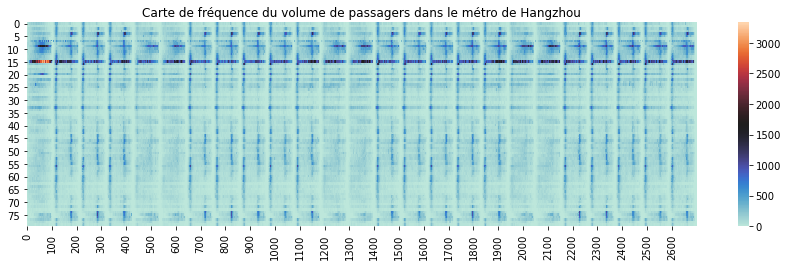

In [6]:
heatmap(matrice)

## Distribution des données

In [7]:
def distribution(matrice):
    sns.set_palette("tab10")
    fig, axes = plt.subplots(2,
                         1,
                         figsize=(15, 15 / 4),
                         sharex=True,
                         gridspec_kw={'height_ratios': [10, 1]})
    ax1, ax2 = axes[0], axes[1]
    sns.distplot(matrice, ax=ax1)
    sns.boxplot(matrice, ax=ax2)
    fig.suptitle(
    'Distribution des valeurs de volume de passagers dans le métro de Hangzhou')
    

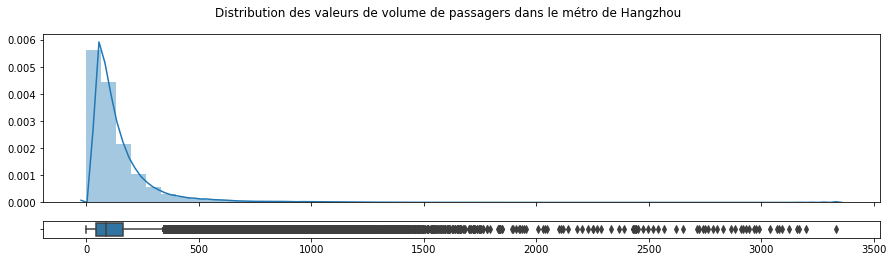

In [8]:
distribution(matrice)

## Trajectoire des stations

In [9]:
def courbes_series(matrice):
    df = pd.DataFrame(matrice).transpose()
    dim1, dim2 = df.shape

    fig, axs = plt.subplots(3, 3, figsize=(20, 10), sharey=True, sharex=True)

    random.seed(2020)
    random_x = random.sample(range(dim2), 10)
    random_x = iter(random_x)
    palette = plt.get_cmap('tab20c')
    num_palette = iter(range(9))

    for i, axe in enumerate(axs):
        for j, ax in enumerate(axe):
            num = next(random_x)
            for v in df:
                sns.lineplot(x=range(dim1),
                             y=df[v],
                             marker="",
                             legend=None,
                             ax=ax,
                             color="grey",
                             linewidth=0.6,
                             alpha=0.3)
            sns.lineplot(range(dim1),
                         df[num],
                         marker='',
                         linewidth=2.4,
                         alpha=0.9,
                         color=palette(next(num_palette)),
                         ax=ax)
            ax.set_title("Station {:}".format(num))
            ax.set_ylabel('Volume de passagers')
    fig.suptitle(
        "Illustration de 9 stations choisies au hasard dans les données du métro de Hanngzhou",
        fontsize=16,
        y=1)

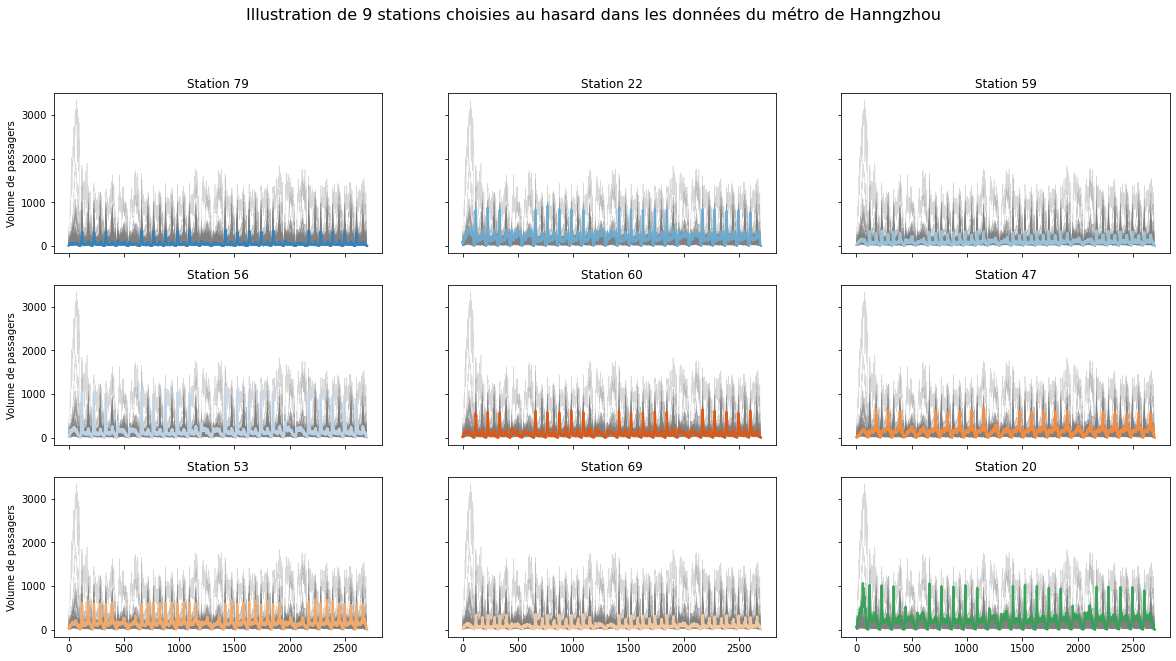

In [10]:
courbes_series(matrice)

Afin de mieux distinguer les différences entre les stations, un autre graphique rapportant la ligne qui contient la plus valeur la plus élevée et une autre ligne choisie au hasard est présentée. 

Text(0.5, 1, 'Illustration de 2 stations dans les données du métro de Hanngzhou')

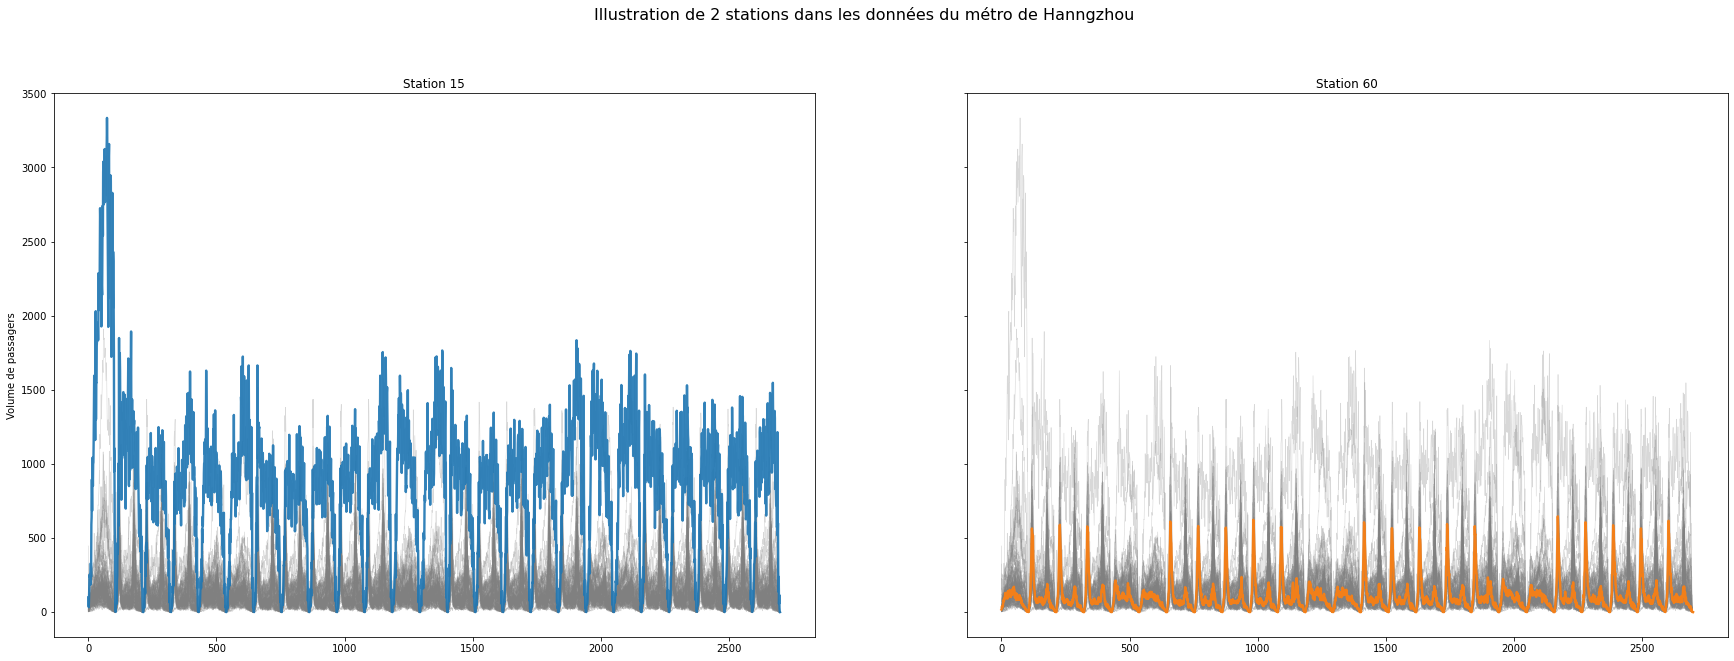

In [11]:
df = pd.DataFrame(matrice).transpose()
dim1, dim2 = df.shape

fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharey=True, sharex=True)

random.seed(2020)
#random_x = random.sample(range(dim2), 10)
random_x = [15, 60]
random_x = iter(random_x)
palette = plt.get_cmap('tab10')
num_palette = iter(range(2))

for i, axe in enumerate(axs):
    num = next(random_x)
    for v in df:
        sns.lineplot(x=range(dim1),
                     y=df[v],
                     marker="",
                     legend=None,
                     ax=axe,
                     color="grey",
                     linewidth=0.6,
                     alpha=0.3)
    sns.lineplot(range(dim1),
                 df[num],
                 marker='',
                 linewidth=2.4,
                 alpha=0.9,
                 color=palette(next(num_palette)),
                 ax=axe)
    axe.set_title("Station {:}".format(num))
    axe.set_ylabel('Volume de passagers')
fig.suptitle(
    "Illustration de 2 stations dans les données du métro de Hanngzhou",
    fontsize=16,
    y=1)

## Autocorrélation

In [12]:
def graph_autocorrelation(matrice):
    height_size = 14
    width_size = 14 / 3

    sns.set_palette("tab10")

    fig, axes = plt.subplots(3,
                             1,
                             figsize=(height_size, width_size),
                             sharex=True,
                             sharey=True)
    ax1, ax2, ax3 = axes[0], axes[1], axes[2]
    dim1, dim2 = matrice.shape

    mi_dim = np.int(dim1 / 2)
    plot_acf(matrice[0], alpha=0.05, ax=ax1, title="")
    plot_acf(matrice[mi_dim], alpha=0.05, ax=ax2, title="")
    plot_acf(matrice[dim1 - 1], alpha=0.05, ax=ax3, title="")
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)

    rows = [
        'Ligne {:}'.format(row)
        for row in ['{:}'.format(1), '{:}'.format(mi_dim), '{:}'.format(dim1)]
    ]
    pad = 5  # in points
    for ax, row in zip(axes, rows):
        ax.annotate(row,
                    xy=(0, 0.5),
                    xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label,
                    textcoords='offset points',
                    size='large',
                    ha='right',
                    va='center',
                    rotation=90)

    fig.suptitle(
        "Autocorrélations des séries temporelles (stations) du métro de Hangzhou"
    )

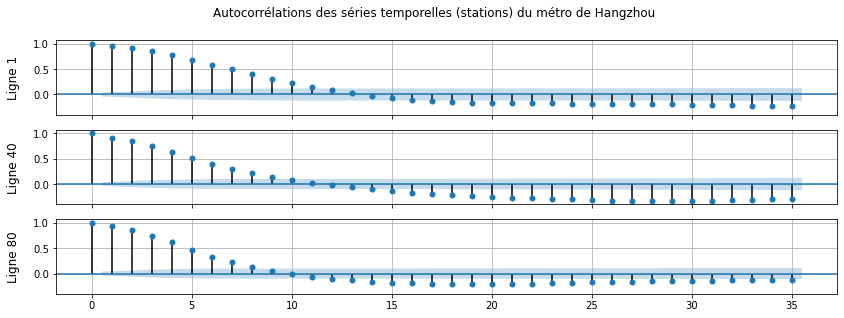

In [13]:
graph_autocorrelation(matrice)

## Corrélations spatiales

In [14]:
corr_p, p_matrix = scipy.stats.spearmanr(matrice.T, axis = 0)

In [15]:
# Masque pour que la partie inférieure soit 
mask_matrix = p_matrix.copy()
mask_matrix[np.where(mask_matrix > 0.05)] = 100
mask_matrix[np.where(mask_matrix < 0.05)] = 1
mask_matrix[np.where(mask_matrix == 100)] = 0
mask = np.zeros_like(corr_p)
mask[np.triu_indices_from(mask)] = True
mask[np.where(mask_matrix == 0)] = 1

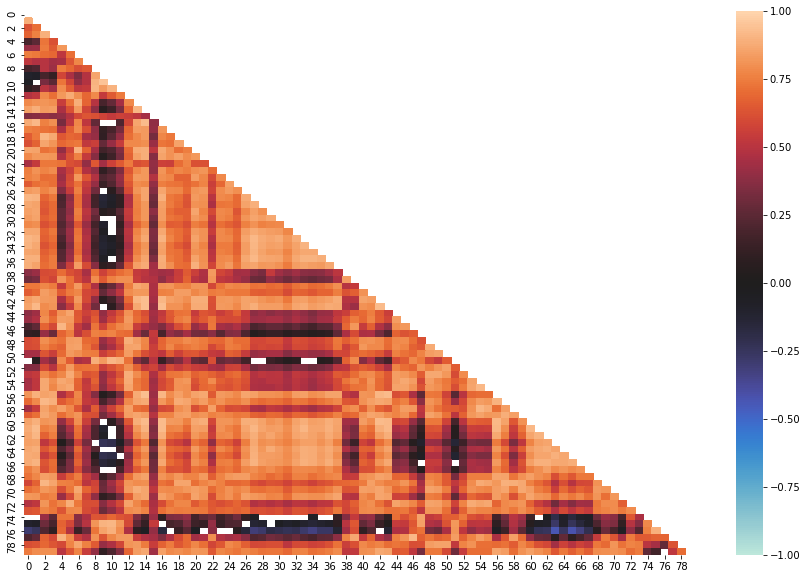

In [16]:
v_min = -1
v_max = 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_p,
            mask=mask,
            annot_kws={"size": 10},
            cmap="icefire",
            cbar_kws=dict(ticks=[1, .75, 0.5, 0.25, 0, -1, -.75, -0.5, -0.25]),
            vmin=v_min,
            vmax=v_max,
            ax=ax)

## Graph cluster des corrélations spatiales

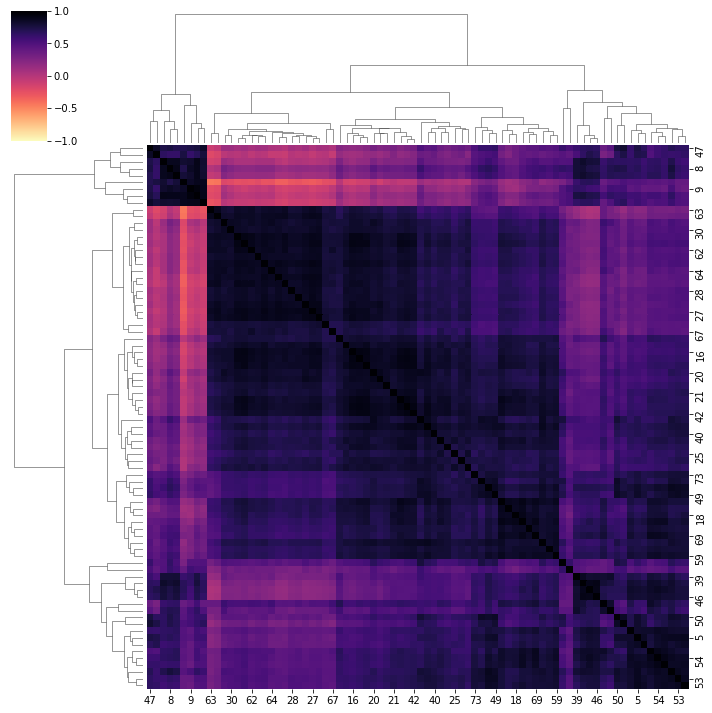

In [17]:
#fig, ax = plt.subplots(1, 1, figsize=(15, 15))

g = sns.clustermap(corr_p,
               row_cluster=True,
               col_cluster=True,
               vmin=v_min,
               vmax=v_max,
               cmap="magma_r")